This notebook best viewed here: https://nbviewer.jupyter.org

First I use LD-pruned SNPs (from 001_JP_pooled_pangenome_data_explore.ipynb) to estimate the covariance matrix across 5 independent runs of the core mode of baypass, and to ensure convergence I calculate the pairwise correlation of the matrices across runs (I found that these runs were highly correlated, r2 > 0.998).

Then I run baypass in STD mode (mcmc) for SNPs in our data.

In [2]:
from pythonimports import *

DIR = '/data/projects/pool_seq/pangenome/JP_pangenome'
snpdir = op.join(DIR, 'JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated')
baydir = makedir(op.join(snpdir, 'baypass'))
op.exists(baydir)

True

# create infiles to baypass to estimate neutral structure

#### <center> genotyping data

"The genotyping data file is simply organized as a matrix with
nsnp rows and 2 ∗ npop columns. The row field separator is a space. More
precisely, each row corresponds to one marker and the number of columns is
twice the number of populations because each pair of numbers corresponds to
each allele (or read counts for PoolSeq experiment) counts in one population"

In [2]:
ls(baydir)

['no-missing-data_20-dp-1000_random-snps_1-per-contig-gt100Kbp_r2-lessthan-p36068.pkl',
 'no-missing-data_20-dp-1000_random-snps_1-per-contig-gt100Kbp_r2-lessthan-p36068.txt']

In [2]:
# load snps that are LD-pruned
# these loci were chosen in 001_JP_pooled_pangenome_data_explore.ipynb
prunedloci = pklload(op.join(baydir, 'no-missing-data_20-dp-1000_random-snps_1-per-contig-gt100Kbp_r2-lessthan-p36068.pkl'))
len(prunedloci)

8591

In [3]:
prunedloci[:5]

['>scaffold125916-52766',
 '>scaffold48955-25539',
 '>scaffold57006-68497',
 '>super297-68268',
 '>super2840-258793']

In [12]:
# load snp data, reduce to only the randomloci
snps = pd.read_table(op.join(snpdir, 'JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt'))
reduced = snps[snps['unstitched_locus'].isin(prunedloci)]
reduced.index = reduced['unstitched_locus'].tolist()  # adding locus name to the index will help look up AD/RD info for a locus
print(reduced.shape, snps.shape)  # want to make sure rows of reduced == len(randomloci)
reduced.head()

(8591, 338) (1235752, 338)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
>super4-47993,Scaffold_1,47993,C,G,0.051569,-10.0,SNP,PASS,66,23,17,0,0,C/C,60.0,44,44.0,4.55%,0.247130,2.0,42.0,C/C,119.0,63,63.0,0%,1.000000,0.0,63.0,C/C,67.0,35,35.0,0%,1.000000e+00,0.0,35.0,C/C,167.0,90,90.0,0%,1.000000e+00,0.0,90.0,C/G,21.0,88,88.0,7.95%,...,26.0,0%,1.000000,0.0,26.0,C/C,74.0,39,39.0,0%,1.000000e+00,0.0,39.0,C/C,142.0,75,75.0,0%,1.000000,0.0,75.0,C/C,89.0,47,47.0,0%,1.000000,0.0,47.0,C/G,31.0,98,98.0,10.2%,0.000767,10.0,88.0,C/G,38.0,67,67.0,17.91%,0.000142,12.0,55.0,Scaffold_1-47993,>super4,47993,>super4-47993,0.051569
>super124-1063998,Scaffold_4,1063998,G,T,0.199180,-10.0,SNP,PASS,65,5,35,0,0,G/T,25.0,58,58.0,13.79%,0.003017,8.0,50.0,G/G,44.0,33,33.0,6.06%,0.246150,2.0,31.0,G/T,63.0,65,65.0,29.23%,4.086100e-07,19.0,46.0,G/T,95.0,54,54.0,48.15%,2.717100e-10,26.0,28.0,G/G,95.0,73,73.0,5.48%,...,33.0,27.27%,0.001042,9.0,24.0,G/T,120.0,71,71.0,46.48%,8.710600e-13,33.0,38.0,G/T,31.0,70,70.0,14.29%,0.000692,10.0,60.0,G/T,15.0,56,56.0,8.93%,0.028473,5.0,51.0,G/T,48.0,74,74.0,20.27%,0.000014,15.0,59.0,G/T,15.0,83,83.0,6.02%,0.029373,5.0,78.0,Scaffold_4-1063998,>super124,1063998,>super124-1063998,0.199180
>super131-87067,Scaffold_5,87067,A,G,0.178779,-10.0,SNP,PASS,68,5,35,0,0,A/G,45.0,68,68.0,20.59%,0.000029,14.0,54.0,A/G,33.0,38,38.0,26.32%,0.000495,10.0,28.0,A/G,21.0,76,76.0,9.21%,6.762200e-03,7.0,69.0,A/A,149.0,79,79.0,0%,1.000000e+00,0.0,79.0,A/G,48.0,84,84.0,17.86%,...,40.0,12.5%,0.027371,5.0,35.0,A/G,28.0,46,46.0,19.57%,1.268200e-03,9.0,37.0,A/G,31.0,66,66.0,15.15%,0.000676,10.0,56.0,A/G,31.0,77,77.0,12.99%,0.000715,10.0,67.0,A/G,41.0,71,71.0,18.31%,0.000067,13.0,58.0,A/G,18.0,66,66.0,9.09%,0.013877,6.0,60.0,Scaffold_5-87067,>super131,87067,>super131-87067,0.178779
>super144-161322,Scaffold_6,161322,A,T,0.065424,-10.0,SNP,PASS,49,28,12,0,0,A/A,71.0,49,49.0,4.08%,0.247420,2.0,47.0,A/A,73.0,45,45.0,2.22%,0.500000,1.0,44.0,A/A,130.0,70,70.0,0%,1.000000e+00,0.0,70.0,A/T,22.0,44,44.0,15.91%,6.036300e-03,7.0,37.0,A/T,18.0,62,62.0,9.68%,...,21.0,9.52%,0.243900,2.0,19.0,A/T,22.0,40,40.0,17.5%,5.868800e-03,7.0,33.0,A/A,57.0,41,41.0,4.88%,0.246910,2.0,39.0,A/A,95.0,63,63.0,3.17%,0.248000,2.0,61.0,A/A,57.0,42,42.0,4.76%,0.246990,2.0,40.0,A/T,21.0,53,53.0,13.21%,0.006325,7.0,46.0,Scaffold_6-161322,>super144,161322,>super144-161322,0.065424
>super215-1038994,Scaffold_7,1038994,G,A,0.072096,-10.0,SNP,PASS,236,0,40,0,0,G/A,36.0,195,195.0,6.15%,0.000205,12.0,183.0,G/A,18.0,223,223.0,2.69%,0.015100,6.0,217.0,G/A,62.0,234,234.0,8.55%,6.242500e-07,20.0,214.0,G/A,58.0,315,315.0,6.03%,1.442000e-06,19.0,296.0,G/A,64.0,280,280.0,7.5%,...,107.0,6.54%,0.007060,7.0,100.0,G/A,36.0,172,172.0,6.98%,2.001800e-04,12.0,160.0,G/A,46.0,256,256.0,5.86%,0.000025,15.0,241.0,G/A,49.0,209,209.0,7.66%,0.000011,16.0,193.0,G/A,42.0,270,270.0,5.19%,0.000051,14.0,256.0,G/A,55.0,268,268.0,6.72%,0.000003,18.0,250.0,Scaffold_7-1038994,>super215,1038994,>super215-1038994,0.072096


In [13]:
snps.head()

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
0,Scaffold_1,15421,A,G,0.674211,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26,26.0,76.92%,1.827300e-09,20.0,6.0,G/G,113.0,28,28.0,85.71%,4.701500e-12,24.0,4.0,A/G,30.0,14,14.0,57.14%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,>super4,15421,>super4-15421,0.325789
1,Scaffold_1,47333,G,A,0.105707,-10.0,SNP,PASS,109,7,33,0,0,G/A,15.0,61,61.0,8.2%,2.870000e-02,5.0,56.0,G/A,34.0,121,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85,85.0,21.18%,1.395700e-06,18.0,67.0,G/G,268.0,144,144.0,0%,1.000000e+00,0.0,144.0,G/A,34.0,133,133.0,8.27%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77,77.0,9.09%,6.775500e-03,7.0,70.0,G/A,18.0,109,109.0,5.5%,1.456000e-02,6.0,103.0,G/A,44.0,103,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,>super4,47333,>super4-47333,0.105707
2,Scaffold_1,47418,T,A,0.217593,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,33.0,155,155.0,7.1%,4.063500e-04,11.0,144.0,T/A,94.0,137,137.0,21.17%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,>super4,47418,>super4-47418,0.217593
3,Scaffold_1,47461,T,G,0.090661,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133,133.0,0%,1.000000e+00,0.0,133.0,T/G,15.0,103,103.0,4.85%,2.973700e-02,5.0,98.0,T/G,235.0,161,161.0,40.99%,2.881900e-24,66.0,95.0,T/G,27.0,120,120.0,7.5%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,>super4,47461,>super4-47461,0.090661
4,Scaffold_1,47513,C,G,0.520739,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,62.0,168,168.0,11.9%,5.230200e-07,20.0,148.0,C/G,179.0,96,96.0,50%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139,139.0,69.78%,1.159100e-41,97.0,42.0,C/G,219.0,120,120.0,49.17%,1.178100e-22,59.0,61.0,Scaffold_1-47513,>super4,47513,>sup

In [19]:
def get_counts(loci, numpops=0):
    """Create gfile for baypass.
    
    Get read counts for global major and minor allele. Missing data = 0."""
    import pandas
    from collections import OrderedDict
    import tqdm
    
    pops = [col.replace(".FREQ","") for col in reduced.columns if '.FREQ' in col]
#     assert len(pops) == numpops
    read_counts = OrderedDict()
    for locus in tqdm.tqdm_notebook(loci):
        if reduced.loc[locus, 'AF'] > 0.5:
            # this matches calculation of MAF from 001_JP_pooled_pangenome_data_explore.ipynb
            refismajor = False
            majortag = 'AD'
            minortag = 'RD'
        else:
            refismajor = True
            majortag = 'RD'
            minortag = 'AD'
        if refismajor is True:
#             print('checking ', locus)
            # double check that it matches MAF calculation
            assert reduced.loc[locus, 'AF'] == reduced.loc[locus, 'MAF']
        for pop in pops:
            for which,tag in zip(['major','minor'],[majortag, minortag]):
                newcol = "%s-%s" % (pop,which)
                if newcol not in read_counts:
                    read_counts[newcol] = OrderedDict()
                if reduced.loc[locus, f"{pop}.FREQ"] != reduced.loc[locus, f"{pop}.FREQ"]:
                    # if locus was filtered for this pop
                    read_counts[newcol][locus] = 0
                else:
                    try:
                        read_counts[newcol][locus] = int(reduced.loc[locus, "%s.%s" % (pop, tag)])
                    except ValueError as e:
                        # missing data - probably don't need this try statement when first looking at FREQ
                        read_counts[newcol][locus] = 0
    return pandas.DataFrame(read_counts)

In [15]:
# get the gfile using the prunedloci
neutral_read_counts = get_counts(prunedloci)
neutral_read_counts.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>scaffold125916-52766,47,20,32,8,53,16,65,22,45,27,63,10,18,23,69,5,52,20,54,16,70,12,46,20,56,3,67,26,70,2,38,22,79,22,82,11,57,33,56,9,59,7,66,16,57,10,44,9,34,11,62,18,35,34,16,10,46,26,30,26,74,5,17,13,26,12,74,31,13,13,44,13,35,30,50,19,58,12,72,16
>scaffold48955-25539,51,11,66,2,84,5,90,0,58,22,67,8,76,1,59,6,76,3,71,11,82,14,70,5,73,3,115,0,82,25,50,13,100,8,77,7,81,8,76,3,79,0,95,0,77,3,73,0,56,4,88,8,81,24,55,1,80,13,65,6,87,15,50,1,43,1,50,11,49,1,73,5,81,7,86,7,88,5,94,0
>scaffold57006-68497,110,8,121,20,145,24,168,0,170,0,113,22,83,7,123,25,140,17,130,33,162,15,133,21,110,19,149,26,129,17,63,33,180,9,183,19,149,18,115,22,116,6,129,32,98,36,63,11,85,8,119,21,156,7,78,5,123,33,80,49,106,23,74,3,90,6,153,7,65,7,91,15,130,17,88,30,106,52,144,12
>super297-68268,168,28,117,16,194,20,210,19,195,22,227,36,118,15,263,28,219,24,220,33,177,25,156,18,217,22,243,43,214,20,155,30,363,53,222,19,322,35,251,23,218,26,203,24,224,15,180,18,133,18,273,19,169,21,92,18,229,24,185,24,208,19,107,16,136,14,193,34,119,11,194,25,198,23,221,41,247,17,187,22
>super2840-258793,56,7,45,0,60,4,65,0,64,1,70,15,33,1,57,3,59,2,65,5,74,3,63,16,50,8,101,2,68,7,42,7,111,3,60,12,68,1,74,6,63,2,76,2,70,6,59,2,47,1,76,4,69,0,32,5,63,4,49,6,70,2,36,2,31,2,58,5,38,1,58,2,60,7,59,2,52,5,64,0


In [21]:
for locus in neutral_read_counts.index:
    ad = reduced.loc[locus, 'JP_p98.AD']
    rd = reduced.loc[locus, 'JP_p98.RD']
    dp = reduced.loc[locus, 'JP_p98.DP']
    assert ad+rd==dp

In [22]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [23]:
# save
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), sep='\t', index=True)
neutral_read_counts.to_csv(op.join(baydir, 'neutral_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)

#### <center> poolsizefile

"For Pool–Seq experiment, the haploid size (twice the number of pooled in- dividuals for diploid species) of each population should be provided. ... The order of the populations in the pool size file must be the same as in the allele count (and the covariate) data file(s)."

In [29]:
# the reason the ploidy.keys() are not in same order of table ...
# ... is because varscan puts Sample1.X then Sample10.X ... (JP_p31 is the 10th file into varscan)
ploidy = pklload(op.join(DIR, 'JP_pooled/pkl_files/ploidy.pkl'))['JP_pooled']
count = 0
for k,v in ploidy.items():
    print(k,v)
    count += 1
    if count == 5:
        break

JP_p98 40
JP_p73 40
JP_p97 40
JP_p60 40
JP_p100 40


In [30]:
# get ploidy of pops in same order as in gfile
pops = [col.replace("-major","") for col in neutral_read_counts.columns if '-major' in col]
vals = OrderedDict()
for pop in pops:
    vals[pop] = OrderedDict()
    vals[pop][0] = ploidy[pop]
poolsizefile = pd.DataFrame(vals)
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [31]:
neutral_read_counts.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>scaffold125916-52766,47,20,32,8,53,16,65,22,45,27,63,10,18,23,69,5,52,20,54,16,70,12,46,20,56,3,67,26,70,2,38,22,79,22,82,11,57,33,56,9,59,7,66,16,57,10,44,9,34,11,62,18,35,34,16,10,46,26,30,26,74,5,17,13,26,12,74,31,13,13,44,13,35,30,50,19,58,12,72,16
>scaffold48955-25539,51,11,66,2,84,5,90,0,58,22,67,8,76,1,59,6,76,3,71,11,82,14,70,5,73,3,115,0,82,25,50,13,100,8,77,7,81,8,76,3,79,0,95,0,77,3,73,0,56,4,88,8,81,24,55,1,80,13,65,6,87,15,50,1,43,1,50,11,49,1,73,5,81,7,86,7,88,5,94,0
>scaffold57006-68497,110,8,121,20,145,24,168,0,170,0,113,22,83,7,123,25,140,17,130,33,162,15,133,21,110,19,149,26,129,17,63,33,180,9,183,19,149,18,115,22,116,6,129,32,98,36,63,11,85,8,119,21,156,7,78,5,123,33,80,49,106,23,74,3,90,6,153,7,65,7,91,15,130,17,88,30,106,52,144,12
>super297-68268,168,28,117,16,194,20,210,19,195,22,227,36,118,15,263,28,219,24,220,33,177,25,156,18,217,22,243,43,214,20,155,30,363,53,222,19,322,35,251,23,218,26,203,24,224,15,180,18,133,18,273,19,169,21,92,18,229,24,185,24,208,19,107,16,136,14,193,34,119,11,194,25,198,23,221,41,247,17,187,22
>super2840-258793,56,7,45,0,60,4,65,0,64,1,70,15,33,1,57,3,59,2,65,5,74,3,63,16,50,8,101,2,68,7,42,7,111,3,60,12,68,1,74,6,63,2,76,2,70,6,59,2,47,1,76,4,69,0,32,5,63,4,49,6,70,2,36,2,31,2,58,5,38,1,58,2,60,7,59,2,52,5,64,0


In [32]:
# save, no need to name as 'neutral'
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_HEADERIDX.txt'), sep='\t', index=False)
poolsizefile.to_csv(op.join(baydir, 'poolsizefile_noheaderidx.txt'), sep='\t', index=False, header=False)

In [86]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


#### <center> create commands to run

#### estimate covariance matrix (run in bash)
```bash
cd /lu213/brandon.lind/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass
mkdir neutral_runs
cd neutral_runs

export gfile="/lu213/brandon.lind/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_gfile_noheaderidx.txt"

export poolsizefile="/lu213/brandon.lind/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/poolsizefile_noheaderidx.txt"



# These commands took about 7 hours each to complete


# chain 1
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_1 > chain_1_stdout.txt &

# chain 2
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_2 > chain_2_stdout.txt &

# chain 3
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_3 > chain_3_stdout.txt &

# chain 4
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_4 > chain_4_stdout.txt &

# chain 5
/data/programs/baypass_2.2/sources/g_baypass -gfile $gfile -poolsizefile $poolsizefile \
-nthreads 8 -seed $seed -print_omega_samples -outprefix chain_5 > chain_5_stdout.txt &

```

# look at covariance matrices output from chains

In [3]:
# get the matrix files output for each chain
ndir = op.join(baydir, 'neutral_runs')
mfiles = fs(ndir, 'mat_omega.out')
mfiles

['/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_1_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_2_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_3_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_4_mat_omega.out',
 '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_runs/chain_5_mat_omega.out']

In [4]:
# get a list of values by vectorizing the matrix for each chain
matrices = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    text = read(m)
    rows = []
    for line in text:
        rows.extend([float(val) for val in line.split()])
    matrices[chain] = rows
len(matrices[chain])  # == 40*40

1600

In [5]:
from scipy.stats import pearsonr

In [6]:
# look at pairwise correlations among chains
for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            print(chaini,chainj,pearsonr(matrices[chaini], matrices[chainj]))

chain_1 chain_2 (0.990914320538268, 0.0)
chain_1 chain_3 (0.9888303504110725, 0.0)
chain_1 chain_4 (0.990913652017176, 0.0)
chain_1 chain_5 (0.9912225847621888, 0.0)
chain_2 chain_3 (0.9880326551959451, 0.0)
chain_2 chain_4 (0.9915429216739118, 0.0)
chain_2 chain_5 (0.9898842945363826, 0.0)
chain_3 chain_4 (0.9939927678355361, 0.0)
chain_3 chain_5 (0.9882812158413585, 0.0)
chain_4 chain_5 (0.991503507799796, 0.0)


chain_1 chain_2 1.0017541164243187 0.0023791272745656775


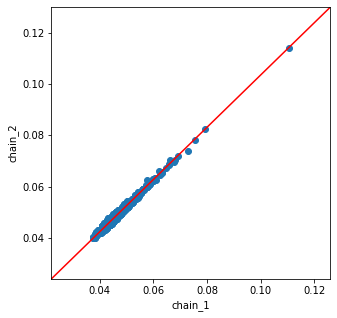

chain_1 chain_3 0.9476158127728702 -0.001557675741933011


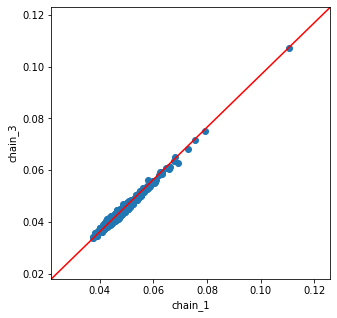

chain_1 chain_4 0.9620584167875249 -0.0026375835203881356


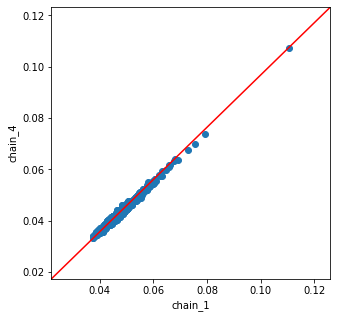

chain_1 chain_5 0.9471247041624158 -0.00036653984318906467


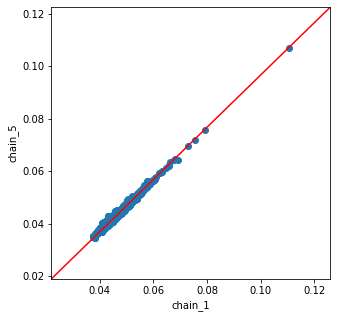

chain_2 chain_3 0.9366056621852265 -0.0033463745799408133


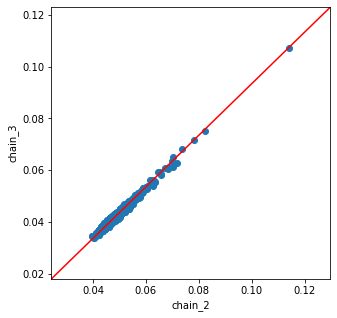

chain_2 chain_4 0.9522524952252809 -0.0045213108088083135


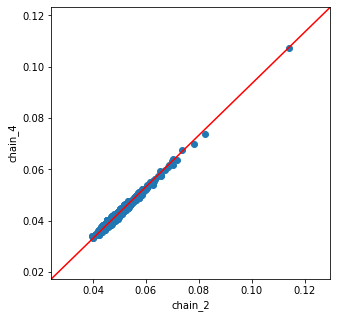

chain_2 chain_5 0.9356111283024302 -0.0021291648917793936


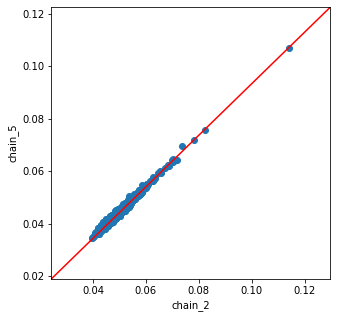

chain_3 chain_4 1.0070205772038836 -0.0007033962212540235


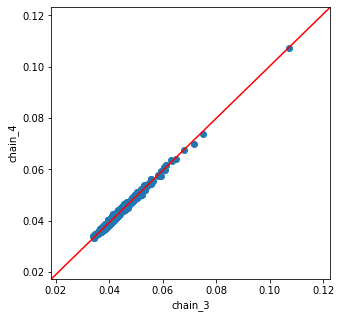

chain_3 chain_5 0.985385132612359 0.0017952709003106026


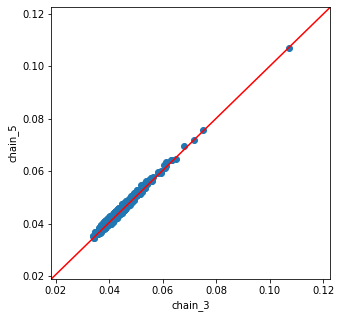

chain_4 chain_5 0.9758085053458306 0.0025986297533838612


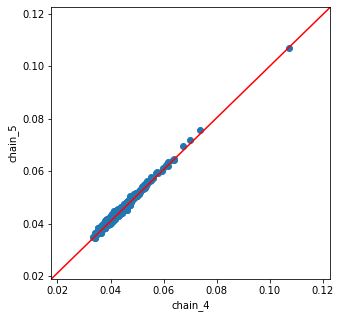

In [7]:
# plot pairwise chains agains 1:1 line, print slope and intercept from data

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

for i,chaini in enumerate(matrices):
    for j,chainj in enumerate(matrices):
        if i < j:
            slope, intercept = np.polyfit(matrices[chaini], matrices[chainj], 1)
            print(chaini, chainj, slope, intercept)
            fig, ax = plt.subplots(figsize=(5,5))
            ax.scatter(matrices[chaini], matrices[chainj])
            ax.set_xlabel(chaini)
            ax.set_ylabel(chainj)
            line = mlines.Line2D([0, 1], [0, 1], color='red')
            transform = ax.transAxes
            line.set_transform(transform)
            ax.add_line(line)           
            
            plt.show()

In [8]:
# make a matrix with the average across matrices
mats = {}
for m in mfiles:
    chain = op.basename(m).split("_mat")[0]
    mats[chain] = pd.read_table(m, delim_whitespace=True, header=None)
mats[chain].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.062418,0.044699,0.051642,0.047507,0.045897,0.045221,0.045925,0.055238,0.044254,0.050529,0.045284,0.042227,0.048069,0.047281,0.045528,0.046810,0.056649,0.044094,0.057366,0.047873,0.057053,0.044767,0.049606,0.051503,0.046125,0.043465,0.046197,0.044871,0.042507,0.044802,0.048186,0.049641,0.051742,0.049234,0.053533,0.052955,0.043695,0.047039,0.044115,0.046480
1,0.044699,0.056307,0.043445,0.044461,0.042477,0.040440,0.045135,0.041735,0.040661,0.039788,0.042846,0.040231,0.041205,0.044086,0.040465,0.045630,0.042751,0.041270,0.043152,0.043173,0.043805,0.041965,0.037582,0.042718,0.044345,0.038428,0.043486,0.041121,0.044271,0.043115,0.041086,0.047737,0.038621,0.044456,0.041409,0.042753,0.040760,0.042082,0.040444,0.041054
2,0.051642,0.043445,0.055173,0.047512,0.043997,0.046773,0.044280,0.048308,0.044292,0.045256,0.044248,0.043243,0.047753,0.046066,0.047186,0.045634,0.050439,0.045049,0.050137,0.047669,0.051735,0.044662,0.042055,0.049139,0.044936,0.043403,0.045257,0.045339,0.040967,0.043062,0.047574,0.048009,0.045922,0.048582,0.048113,0.048114,0.043529,0.047991,0.043121,0.047925
3,0.047507,0.044461,0.047512,0.106796,0.044730,0.044432,0.047117,0.045180,0.044345,0.042694,0.044924,0.044076,0.045891,0.047909,0.046248,0.047290,0.045535,0.046907,0.046427,0.047875,0.048971,0.046356,0.040844,0.047167,0.046129,0.042501,0.046845,0.045196,0.043414,0.045234,0.044749,0.051189,0.042102,0.048431,0.045881,0.045444,0.043956,0.046655,0.045162,0.047143
4,0.045897,0.042477,0.043997,0.044730,0.064308,0.040964,0.045092,0.043081,0.042218,0.039666,0.042673,0.040270,0.041664,0.044985,0.039913,0.046167,0.044153,0.042149,0.043756,0.044815,0.044956,0.041626,0.037721,0.042778,0.043793,0.042442,0.044229,0.041089,0.041621,0.043873,0.041549,0.048334,0.039980,0.045345,0.041955,0.043038,0.041016,0.041633,0.041594,0.040706


In [9]:
keys(mats)

['chain_1', 'chain_2', 'chain_3', 'chain_4', 'chain_5']

In [10]:
for chain,m in mats.items():
    print(chain)
    if chain == 'chain_1':
        summatrix = np.array(m)
    else:
        summatrix = summatrix + np.array(m)
summatrix

chain_1
chain_2
chain_3
chain_4
chain_5


array([[0.317426, 0.225254, 0.263426, ..., 0.240845, 0.226556, 0.238995],
       [0.225254, 0.284309, 0.220017, ..., 0.21246 , 0.206759, 0.206717],
       [0.263426, 0.220017, 0.280496, ..., 0.245864, 0.221684, 0.244709],
       ...,
       [0.240845, 0.21246 , 0.245864, ..., 0.267461, 0.213135, 0.2404  ],
       [0.226556, 0.206759, 0.221684, ..., 0.213135, 0.331975, 0.209439],
       [0.238995, 0.206717, 0.244709, ..., 0.2404  , 0.209439, 0.280013]])

In [11]:
avg = summatrix / len(mats)
avg.shape

(40, 40)

In [12]:
avgmat = pd.DataFrame(avg)
avgmat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.063485,0.045051,0.052685,0.049211,0.047012,0.046256,0.046858,0.056151,0.045058,0.051376,0.045960,0.043080,0.048957,0.048191,0.046765,0.048230,0.057841,0.044488,0.058611,0.049009,0.058394,0.045768,0.050949,0.052740,0.047412,0.044699,0.047146,0.046408,0.043213,0.045936,0.049205,0.051225,0.053057,0.050219,0.054660,0.053474,0.044809,0.048169,0.045311,0.047799
1,0.045051,0.056862,0.044003,0.045826,0.043384,0.041244,0.045475,0.041977,0.040866,0.040201,0.042892,0.040261,0.041327,0.045045,0.041285,0.046839,0.043525,0.041176,0.043919,0.043915,0.044751,0.042560,0.038372,0.043091,0.044906,0.038983,0.044217,0.042092,0.044538,0.043949,0.041519,0.048761,0.039616,0.045049,0.042108,0.042857,0.041083,0.042492,0.041352,0.041343
2,0.052685,0.044003,0.056099,0.048969,0.045346,0.047845,0.044743,0.049227,0.045092,0.046049,0.044801,0.044008,0.048578,0.047247,0.048451,0.047070,0.051543,0.045534,0.051554,0.048420,0.053065,0.045824,0.043465,0.050261,0.046009,0.044454,0.046292,0.047012,0.042003,0.044445,0.048140,0.049669,0.047315,0.049732,0.049136,0.048576,0.044725,0.049173,0.044337,0.048942
3,0.049211,0.045826,0.048969,0.109216,0.046630,0.046330,0.048293,0.046461,0.045400,0.043717,0.046098,0.045105,0.047188,0.049603,0.047905,0.049171,0.047592,0.047561,0.048206,0.049469,0.050465,0.047947,0.042542,0.048629,0.047881,0.043998,0.048173,0.047370,0.044736,0.046869,0.046015,0.053058,0.044242,0.050122,0.047428,0.046545,0.045904,0.047824,0.046889,0.048667
4,0.047012,0.043384,0.045346,0.046630,0.065740,0.042389,0.046044,0.044013,0.043339,0.040898,0.043328,0.041020,0.042688,0.046183,0.041303,0.047705,0.045466,0.042678,0.044915,0.046123,0.046313,0.043159,0.039173,0.044170,0.045463,0.043748,0.045837,0.043128,0.042739,0.045415,0.042754,0.049914,0.041748,0.046789,0.043048,0.043878,0.042342,0.042989,0.042820,0.042084


In [13]:
avgmat.shape

(40, 40)

In [14]:
# make sure avgmat is highly correlated with other chains
avgmatlst = []
for row in avgmat.index:
    for col in avgmat.columns:
        avgmatlst.append(avgmat.loc[row, col])
len(avgmatlst), len(matrices[chain])

(1600, 1600)

In [15]:
for chain,lst in matrices.items():
    print(chain, pearsonr(matrices[chain], avgmatlst))

chain_1 (0.9962105074800831, 0.0)
chain_2 (0.9959372135964493, 0.0)
chain_3 (0.9955544120405253, 0.0)
chain_4 (0.9973559898873823, 0.0)
chain_5 (0.9959264508728967, 0.0)


#### make sure pops are in same order as gfile

In [16]:
poolsizefile = pd.read_table(op.join(baydir, 'poolsizefile_HEADERIDX.txt'))
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [17]:
gfile = pd.read_table(op.join(baydir, 'neutral_gfile_HEADERIDX.txt'), index_col=0)
gfilecols = [list(gfile.columns)[i].split("-")[0] for i in range(0,len(gfile.columns),2)]
pd.DataFrame(columns=gfilecols)  # just so it prints pretty

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79


In [18]:
list(poolsizefile.columns) == gfilecols

True

In [19]:
# now apply to avgmat
avgmat.columns = gfilecols
avgmat.index = gfilecols
avgmat.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
JP_p98,0.063485,0.045051,0.052685,0.049211,0.047012,0.046256,0.046858,0.056151,0.045058,0.051376,0.045960,0.043080,0.048957,0.048191,0.046765,0.048230,0.057841,0.044488,0.058611,0.049009,0.058394,0.045768,0.050949,0.052740,0.047412,0.044699,0.047146,0.046408,0.043213,0.045936,0.049205,0.051225,0.053057,0.050219,0.054660,0.053474,0.044809,0.048169,0.045311,0.047799
JP_p31,0.045051,0.056862,0.044003,0.045826,0.043384,0.041244,0.045475,0.041977,0.040866,0.040201,0.042892,0.040261,0.041327,0.045045,0.041285,0.046839,0.043525,0.041176,0.043919,0.043915,0.044751,0.042560,0.038372,0.043091,0.044906,0.038983,0.044217,0.042092,0.044538,0.043949,0.041519,0.048761,0.039616,0.045049,0.042108,0.042857,0.041083,0.042492,0.041352,0.041343
JP_p93,0.052685,0.044003,0.056099,0.048969,0.045346,0.047845,0.044743,0.049227,0.045092,0.046049,0.044801,0.044008,0.048578,0.047247,0.048451,0.047070,0.051543,0.045534,0.051554,0.048420,0.053065,0.045824,0.043465,0.050261,0.046009,0.044454,0.046292,0.047012,0.042003,0.044445,0.048140,0.049669,0.047315,0.049732,0.049136,0.048576,0.044725,0.049173,0.044337,0.048942
JP_p24,0.049211,0.045826,0.048969,0.109216,0.046630,0.046330,0.048293,0.046461,0.045400,0.043717,0.046098,0.045105,0.047188,0.049603,0.047905,0.049171,0.047592,0.047561,0.048206,0.049469,0.050465,0.047947,0.042542,0.048629,0.047881,0.043998,0.048173,0.047370,0.044736,0.046869,0.046015,0.053058,0.044242,0.050122,0.047428,0.046545,0.045904,0.047824,0.046889,0.048667
JP_p14,0.047012,0.043384,0.045346,0.046630,0.065740,0.042389,0.046044,0.044013,0.043339,0.040898,0.043328,0.041020,0.042688,0.046183,0.041303,0.047705,0.045466,0.042678,0.044915,0.046123,0.046313,0.043159,0.039173,0.044170,0.045463,0.043748,0.045837,0.043128,0.042739,0.045415,0.042754,0.049914,0.041748,0.046789,0.043048,0.043878,0.042342,0.042989,0.042820,0.042084


In [20]:
avgmat.shape

(40, 40)

In [21]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [22]:
# save avgmatrix
avgmat.to_csv(op.join(baydir, 'neutral_omegafile_HEADERIDX.txt'), sep='\t', index=True, header=True)
avgmat.to_csv(op.join(baydir, 'neutral_omegafile_noheaderidx.txt'), sep='\t', index=False, header=False)

# make efile

In [23]:
avgmat = pd.read_table(op.join(baydir, 'neutral_omegafile_HEADERIDX.txt'), index_col=0)
gfilecols = list(avgmat.columns)

In [24]:
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_std_env-19variables.txt')
envdata

,id1,id2,our_id,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
0,9150251,38,JP_p98,54.3333,-106.6333,537,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
1,3273,22,JP_p73,44.4200,-84.6800,359,0.861856,1.380348,1.500889,-1.335983,1.470853,0.696905,1.922962,1.056481,-0.138853,1.486412,1.414019,-0.056960,1.214977,0.923098,-0.803992,0.339162,-1.165432,-0.735070,1.016494
2,8060006,37,JP_p97,56.1167,-116.9167,636,1.161285,1.394176,-1.225419,0.745700,-0.648921,-0.361685,-0.477565,-1.807367,-1.260140,-0.939544,-0.945179,-1.555599,-1.674698,-0.676726,-0.864621,1.013853,0.465168,0.749920,-2.316274
3,3260,17,JP_p60,46.7200,-84.3900,203,-0.236050,-0.085386,0.084487,-0.837726,0.909736,-0.655738,0.068586,0.497681,0.294712,0.622936,0.874203,-0.032592,-0.229861,0.475148,0.278680,-0.262870,-1.053748,0.155924,1.016494
4,9040116,40,JP_p100,55.7667,-97.8167,205,-0.874832,-0.154524,-1.882146,2.424876,-1.771154,-0.126443,-1.849295,-2.366167,-0.983556,-2.378670,-1.964832,-1.031685,-1.477675,-2.724500,-0.362262,0.328782,1.693702,2.531907,-1.871904
5,3242,13,JP_p42,45.5085,-76.9384,281,0.103303,0.523032,1.302096,-0.951208,0.847390,0.520473,1.033878,1.266030,0.257335,1.116351,0.794230,-0.154433,1.477675,0.987091,0.088129,0.557139,-0.383638,-1.180566,1.127586
6,5850405,43,JP_p103,53.1167,-106.0667,485,2.179344,1.961111,-0.018459,0.511644,-0.794396,-0.067632,0.030483,0.218281,-1.364793,-0.405011,-0.265410,-1.592152,-0.098512,0.667127,-1.133124,1.999940,0.264135,-1.477564,-0.760982
7,3248,14,JP_p48,46.7400,-75.8800,248,-0.715136,-0.541699,0.187434,-0.307554,0.036888,-0.126443,0.373415,0.218281,0.631098,0.293993,0.174441,0.747187,0.032837,0.027197,0.651119,-0.802623,-0.182605,0.007425,0.349941
8,3279,24,JP_p79,46.7000,-92.5000,377,0.063379,0.246478,0.727015,-0.385572,0.016106,1.579063,1.414914,-0.200819,-0.004298,0.540700,0.214427,0.917764,0.886605,-0.548740,-0.674071,-0.626165,0.085439,0.601421,0.127756
9,3231,10,JP_p31,48.7200,-71.8700,111,-0.715136,-1.067151,-0.266951,0.123323,-0.357972,-0.302874,-0.401358,0.078581,0.309662,-0.158304,-0.225423,0.613163,-0.295535,-0.292768,0.477891,-0.823383,0.152450,0.155924,0.238848


In [32]:
# double check centered/standardized
for env in list(envdata.columns)[6:]:
    print(env, np.mean(envdata[env]), np.std(envdata[env]))

AHM 4.884981308350689e-16 0.9999999999999999
CMD -1.6653345369377348e-16 0.9999999999999999
DD5 -2.1094237467877973e-16 0.9999999999999998
DD_0 -6.661338147750939e-17 1.0
EMT -1.126876369994534e-15 1.0
EXT 8.715250743307478e-16 0.9999999999999998
Eref -3.108624468950438e-16 1.0
FFP -5.551115123125783e-18 1.0
MAP 9.992007221626409e-17 1.0
MAT -1.6653345369377348e-16 0.9999999999999999
MCMT -2.7755575615628914e-17 1.0
MSP -1.2212453270876723e-16 1.0000000000000002
MWMT 5.995204332975846e-16 1.0
NFFD 7.216449660063518e-16 1.0
PAS 6.661338147750939e-17 1.0000000000000002
SHM -1.4432899320127036e-16 1.0
TD 4.440892098500626e-16 0.9999999999999999
bFFP 1.6986412276764896e-15 1.0000000000000002
eFFP -2.55351295663786e-15 0.9999999999999998


In [33]:
# convert jp envdata to efile, making sure to order pops in same order as other files
envdata.index = envdata['our_id'].tolist()
efile = envdata.loc[gfilecols, list(envdata.columns)[6:]]
efile.head()

,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
JP_p98,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
JP_p31,-0.715136,-1.067151,-0.266951,0.123323,-0.357972,-0.302874,-0.401358,0.078581,0.309662,-0.158304,-0.225423,0.613163,-0.295535,-0.292768,0.477891,-0.823383,0.152450,0.155924,0.238848
JP_p93,1.201209,0.633654,0.560171,0.488593,-0.461882,1.285011,-0.261645,0.846931,-0.961130,-0.158304,-0.665274,-0.824556,0.886605,0.539141,-0.951235,1.200691,1.068267,-1.032068,0.572125
JP_p24,-1.313994,-1.606431,0.407526,-1.109019,0.826608,-0.420495,1.249798,0.148431,2.077558,0.910761,1.134115,2.233642,0.098512,-0.100789,1.439303,-1.633012,-1.232443,-0.141074,0.238848
JP_p14,-1.174261,-1.177773,-0.515443,-0.389119,0.265491,-0.596927,-0.083828,-0.619918,1.139415,0.047286,0.414359,0.929948,-0.361209,-1.060683,1.768435,-1.062120,-0.584671,0.898419,-0.316613


In [34]:
# compare to above to make sure it copied over OK
envdata.loc[gfilecols, :].head()

,id1,id2,our_id,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
JP_p98,9150251,38,JP_p98,54.3333,-106.6333,537,0.702161,0.550687,-0.923679,1.114516,-1.002217,-0.420495,-0.756992,-0.899318,-1.151749,-1.104016,-1.005158,-1.153526,-0.886605,0.027197,-0.899267,0.795876,0.822560,0.304423,-1.205351
JP_p31,3231,10,JP_p31,48.7200,-71.8700,111,-0.715136,-1.067151,-0.266951,0.123323,-0.357972,-0.302874,-0.401358,0.078581,0.309662,-0.158304,-0.225423,0.613163,-0.295535,-0.292768,0.477891,-0.823383,0.152450,0.155924,0.238848
JP_p93,8940116,33,JP_p93,50.5500,-96.1500,236,1.201209,0.633654,0.560171,0.488593,-0.461882,1.285011,-0.261645,0.846931,-0.961130,-0.158304,-0.665274,-0.824556,0.886605,0.539141,-0.951235,1.200691,1.068267,-1.032068,0.572125
JP_p24,3224,6,JP_p24,43.9500,-71.2500,476,-1.313994,-1.606431,0.407526,-1.109019,0.826608,-0.420495,1.249798,0.148431,2.077558,0.910761,1.134115,2.233642,0.098512,-0.100789,1.439303,-1.633012,-1.232443,-0.141074,0.238848
JP_p14,3214,4,JP_p14,47.3793,-66.6966,313,-1.174261,-1.177773,-0.515443,-0.389119,0.265491,-0.596927,-0.083828,-0.619918,1.139415,0.047286,0.414359,0.929948,-0.361209,-1.060683,1.768435,-1.062120,-0.584671,0.898419,-0.316613


In [35]:
######################### VERY IMPORTANT!
# transpose df so pops are columns and env are rows
#########################
efile = efile.T
efile.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
AHM,0.702161,-0.715136,1.201209,-1.313994,-1.174261,0.083341,-0.894794,0.762047,0.123265,0.522504,-1.413804,0.861856,0.901780,-1.054489,0.362808,-0.834908,0.861856,0.622313,1.201209,-0.735098,1.979725,0.103303,1.161285,1.281057,-1.513613,0.043417,-0.615327,0.542465,-0.894794,-1.713233,-1.114375,-1.313994,1.181247,-0.236050,0.282960,-0.874832,0.103303,2.179344,-0.715136,0.063379
CMD,0.550687,-1.067151,0.633654,-1.606431,-1.177773,-0.030075,-0.361940,0.882552,0.052891,0.232651,-1.454326,1.380348,0.536860,-1.053324,0.315617,-0.762942,0.412411,1.560108,0.550687,-0.071558,2.182354,0.536860,1.394176,1.020829,-1.634086,-0.624666,-0.597010,-0.016248,-1.246911,-1.606431,-0.583182,-1.634086,0.993173,-0.085386,0.343272,-0.154524,0.523032,1.961111,-0.541699,0.246478
DD5,-0.923679,-0.266951,0.560171,0.407526,-0.515443,1.074904,0.670217,-1.001776,0.808663,-0.515443,-0.866881,1.500889,0.379127,-0.302450,2.193116,0.698616,-0.810083,1.795529,-0.952078,-0.593540,0.755414,1.216899,-1.225419,0.048988,-1.378063,0.290380,1.273697,0.659568,-0.053958,-2.169687,-1.310616,-0.327299,-0.639688,0.084487,-0.881080,-1.882146,1.302096,-0.018459,0.187434,0.727015
DD_0,1.114516,0.123323,0.488593,-1.109019,-0.389119,-0.647999,-1.330663,1.462054,-1.477835,1.327294,0.327236,-1.335983,0.479727,-0.568207,-1.077102,-1.516844,1.148206,-1.422867,0.513417,0.235032,0.352060,-1.174626,0.745700,0.694278,0.933654,0.426532,-0.837726,0.431852,-0.493735,0.630445,0.891098,-1.653377,0.912376,-0.837726,1.343253,2.424876,-0.951208,0.511644,-0.307554,-0.385572
EMT,-1.002217,-0.357972,-0.461882,0.826608,0.265491,0.348620,1.263032,-1.480205,1.907277,-0.877524,-0.420318,1.470853,-0.503446,0.348620,0.826608,1.699456,-1.043781,1.637110,-0.856742,-0.524228,-0.337190,1.117557,-0.648921,-0.752832,-0.835960,-0.482664,0.639569,-0.295625,0.494094,-0.628139,-0.939870,2.406047,-0.919088,0.909736,-1.126909,-1.771154,0.847390,-0.794396,0.036888,0.016106


In [36]:
# save
efile.to_csv(op.join(baydir, 'efile_std_HEADERIDX.txt'), sep='\t', index=True, header=True)
efile.to_csv(op.join(baydir, 'efile_std_noheaderidx.txt'), sep='\t', index=False, header=False)

In [37]:
efile.head()

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
AHM,0.702161,-0.715136,1.201209,-1.313994,-1.174261,0.083341,-0.894794,0.762047,0.123265,0.522504,-1.413804,0.861856,0.901780,-1.054489,0.362808,-0.834908,0.861856,0.622313,1.201209,-0.735098,1.979725,0.103303,1.161285,1.281057,-1.513613,0.043417,-0.615327,0.542465,-0.894794,-1.713233,-1.114375,-1.313994,1.181247,-0.236050,0.282960,-0.874832,0.103303,2.179344,-0.715136,0.063379
CMD,0.550687,-1.067151,0.633654,-1.606431,-1.177773,-0.030075,-0.361940,0.882552,0.052891,0.232651,-1.454326,1.380348,0.536860,-1.053324,0.315617,-0.762942,0.412411,1.560108,0.550687,-0.071558,2.182354,0.536860,1.394176,1.020829,-1.634086,-0.624666,-0.597010,-0.016248,-1.246911,-1.606431,-0.583182,-1.634086,0.993173,-0.085386,0.343272,-0.154524,0.523032,1.961111,-0.541699,0.246478
DD5,-0.923679,-0.266951,0.560171,0.407526,-0.515443,1.074904,0.670217,-1.001776,0.808663,-0.515443,-0.866881,1.500889,0.379127,-0.302450,2.193116,0.698616,-0.810083,1.795529,-0.952078,-0.593540,0.755414,1.216899,-1.225419,0.048988,-1.378063,0.290380,1.273697,0.659568,-0.053958,-2.169687,-1.310616,-0.327299,-0.639688,0.084487,-0.881080,-1.882146,1.302096,-0.018459,0.187434,0.727015
DD_0,1.114516,0.123323,0.488593,-1.109019,-0.389119,-0.647999,-1.330663,1.462054,-1.477835,1.327294,0.327236,-1.335983,0.479727,-0.568207,-1.077102,-1.516844,1.148206,-1.422867,0.513417,0.235032,0.352060,-1.174626,0.745700,0.694278,0.933654,0.426532,-0.837726,0.431852,-0.493735,0.630445,0.891098,-1.653377,0.912376,-0.837726,1.343253,2.424876,-0.951208,0.511644,-0.307554,-0.385572
EMT,-1.002217,-0.357972,-0.461882,0.826608,0.265491,0.348620,1.263032,-1.480205,1.907277,-0.877524,-0.420318,1.470853,-0.503446,0.348620,0.826608,1.699456,-1.043781,1.637110,-0.856742,-0.524228,-0.337190,1.117557,-0.648921,-0.752832,-0.835960,-0.482664,0.639569,-0.295625,0.494094,-0.628139,-0.939870,2.406047,-0.919088,0.909736,-1.126909,-1.771154,0.847390,-0.794396,0.036888,0.016106


In [38]:
efile.shape

(19, 40)

In [39]:
# save a separate efile for each env, in case I want to run the MCMC algorithm
envdir = makedir(op.join(baydir, 'individual_efiles'))
for env in efile.index:
    df = pd.DataFrame(efile.loc[env, :]).T
    df.to_csv(op.join(envdir, '%s_HEADERIDX.txt' % env), sep='\t', index=True, header=True)
    df.to_csv(op.join(envdir, '%s_noheaderidx.txt' % env), sep='\t', index=False, header=False)
df

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
eFFP,-1.205351,0.238848,0.572125,0.238848,-0.316613,0.461033,0.79431,-1.538628,1.905232,-0.205521,-0.205521,1.016494,0.127756,-0.205521,1.127586,1.349771,-0.872074,1.349771,-1.316443,-0.427705,-0.205521,1.127586,-2.316274,-0.205521,-0.64989,0.461033,1.016494,0.572125,0.461033,-1.316443,-0.983166,1.349771,-1.205351,1.016494,-0.983166,-1.871904,1.127586,-0.760982,0.349941,0.127756


# create gfiles for GEA from "SNP" files (ADP < 1000)

In [15]:
def get_skipto_df(f, skipto, nrows, cols=None, filter_maf=False, **kwargs):
    """Retrieve dataframe in parallel so that all rows are captured when iterating.
    
    f = filename to open
    skipto = row number to skip, read rows thereafter
    nrows = how many rows to read from f after skipto
    """
    import pandas
    
    if skipto == 0:
        df = pandas.read_table(f, nrows=nrows-1)
    else:
        df = pandas.read_table(f, skiprows=range(1, skipto), nrows=nrows)
    
    if cols is not None:
        if isinstance(cols, str):
            cols = [cols]
        df = df[cols].copy()
    
    if filter_maf is True:
        return maf_filter(df, **kwargs)
    
    return df

In [12]:
lview,dview = get_client()

56 56


In [13]:
# get linenums for each variety and each type
linenums = {}
for f in fs(snpdir, pattern='SNP', dirs=False):
    out = !wc -l $f
    linenums[f] = int(out[0].split()[0])-1
    print(op.basename(f), linenums[f])

JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt 1235752


In [16]:
# read in snps in parallel
f = keys(linenums)[0]
nrows = 10000
jobs = []
for skipto in range(0, linenums[f], nrows):
    jobs.append(lview.apply_async(get_skipto_df, *(f, skipto, nrows)))
watch_async(jobs)

124
124


In [17]:
# get job returns
snps = pd.concat([j.r for j in jobs])
snps.index = snps['locus'].tolist()
print(snps.shape)
snps.head()

(1235752, 338)


,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
Scaffold_1-15421,Scaffold_1,15421,A,G,0.674211,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26,26.0,76.92%,1.827300e-09,20.0,6.0,G/G,113.0,28,28.0,85.71%,4.701500e-12,24.0,4.0,A/G,30.0,14,14.0,57.14%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,>super4,15421,>super4-15421,0.325789
Scaffold_1-47333,Scaffold_1,47333,G,A,0.105707,-10.0,SNP,PASS,109,7,33,0,0,G/A,15.0,61,61.0,8.2%,2.870000e-02,5.0,56.0,G/A,34.0,121,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85,85.0,21.18%,1.395700e-06,18.0,67.0,G/G,268.0,144,144.0,0%,1.000000e+00,0.0,144.0,G/A,34.0,133,133.0,8.27%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77,77.0,9.09%,6.775500e-03,7.0,70.0,G/A,18.0,109,109.0,5.5%,1.456000e-02,6.0,103.0,G/A,44.0,103,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,>super4,47333,>super4-47333,0.105707
Scaffold_1-47418,Scaffold_1,47418,T,A,0.217593,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,33.0,155,155.0,7.1%,4.063500e-04,11.0,144.0,T/A,94.0,137,137.0,21.17%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,>super4,47418,>super4-47418,0.217593
Scaffold_1-47461,Scaffold_1,47461,T,G,0.090661,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133,133.0,0%,1.000000e+00,0.0,133.0,T/G,15.0,103,103.0,4.85%,2.973700e-02,5.0,98.0,T/G,235.0,161,161.0,40.99%,2.881900e-24,66.0,95.0,T/G,27.0,120,120.0,7.5%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,>super4,47461,>super4-47461,0.090661
Scaffold_1-47513,Scaffold_1,47513,C,G,0.520739,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,62.0,168,168.0,11.9%,5.230200e-07,20.0,148.0,C/G,179.0,96,96.0,50%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139,139.0,69.78%,1.159100e-41,97.0,42.0,C/G,219.0,

In [18]:
# reduce snps to those with ADP < 1000
reduced = snps[snps['ADP'] < 1000].copy()
reduced.shape, snps.shape

((1235028, 338), (1235752, 338))

In [20]:
# test function
x = get_counts(reduced.index[:5])
x.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_1-15421,16,6,27,5,20,6,24,4,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
Scaffold_1-47333,56,5,110,11,67,18,144,0,122,11,102,16,87,5,81,4,131,5,93,8,135,9,125,7,95,9,169,16,102,23,62,5,100,23,149,5,92,23,119,3,78,12,122,5,87,7,80,14,74,2,110,7,142,5,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,103,6,89,14,134,0,96,9
Scaffold_1-47418,56,14,114,26,72,25,144,11,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
Scaffold_1-47461,77,0,133,0,98,5,95,66,111,9,96,19,91,6,103,6,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,80,6,95,3,67,12,127,14,120,16,78,5,119,15,124,8,104,12,54,5,67,0,93,6,46,0,74,10,100,2,89,2,99,24,101,24
Scaffold_1-47513,43,34,75,58,38,59,20,148,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [21]:
# get a list of cols necessary for get_counts() to save mem on engines
important_cols = [col for col in reduced.columns if '.FREQ' in col]
important_cols.extend([col for col in reduced.columns if 'AD' in col or 'RD' in col])
important_cols.extend(['AF', 'MAF'])
len(important_cols)

123

In [64]:
# restart engines
lview,dview = get_client()

15 15


In [70]:
# load reduced to engines, but only important columns
dview['reduced'] = reduced[important_cols]

In [66]:
# thresh to evenly distribute jobs
thresh = math.ceil(nrow(reduced) / len(lview))
thresh

82336

In [67]:
nrow(reduced)

1235028

In [71]:
# send jobs to engines for get_counts()
jobs = []
tosend = []
for i,locus in enumerate(reduced.index):
    tosend.append(locus)
    if len(tosend) == thresh or (i+1)==nrow(reduced):
        jobs.append(lview.apply_async(get_counts, tosend))
        tosend = []
watch_async(jobs)

15
15


In [72]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])

In [73]:
# get jobs returns
gfile = pd.concat([j.r for j in jobs])
gfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_1-15421,16,6,27,5,20,6,24,4,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
Scaffold_1-47333,56,5,110,11,67,18,144,0,122,11,102,16,87,5,81,4,131,5,93,8,135,9,125,7,95,9,169,16,102,23,62,5,100,23,149,5,92,23,119,3,78,12,122,5,87,7,80,14,74,2,110,7,142,5,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,103,6,89,14,134,0,96,9
Scaffold_1-47418,56,14,114,26,72,25,144,11,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
Scaffold_1-47461,77,0,133,0,98,5,95,66,111,9,96,19,91,6,103,6,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,80,6,95,3,67,12,127,14,120,16,78,5,119,15,124,8,104,12,54,5,67,0,93,6,46,0,74,10,100,2,89,2,99,24,101,24
Scaffold_1-47513,43,34,75,58,38,59,20,148,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [74]:
# make sure returns make sense
nrow(reduced) == nrow(gfile)

True

In [75]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [76]:
def write_file(df, filepath):
    import pandas
    if 'noheader' in filepath:
        index=False
        header=False
    else:
        index = True
        header=True
    df.to_csv(filepath, sep='\t', header=header, index=index)
    return filepath

In [77]:
gfile.shape

(1235028, 80)

In [78]:
jobs = []
files = [op.join(baydir, 'all_snps_ADP-lt-1000_gfile_HEADERIDX.txt'),
         op.join(baydir, 'all_snps_ADP-lt-1000_gfile_noheaderidx.txt')]
for f in files:
    jobs.append(lview.apply_async(write_file, *(gfile, f)))

In [80]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [79]:
# create dir for individual gfiles
gfile_dir = makedir(op.join(baydir, 'individual_gfiles'))
gfile_dir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_gfiles'

In [83]:
# write small gfiles to parallelize baypass
newjobs = []
tosend = []
jobcount = 0
for i,locus in enumerate(gfile.index):
    tosend.append(locus)
    if len(tosend) == 10000 or (i+1) == len(gfile.index):
        smallgfile = gfile.loc[tosend, :].copy()
        for bname in ['all_snps_ADP-lt-1000_gfile_HEADERIDX.txt',
                      'all_snps_ADP-lt-1000_gfile_noheaderidx.txt']:
            bname = bname.replace('_gfile', '_gfile_%s' % str(jobcount).zfill(4))  # I changed this line
            smallpath = op.join(gfile_dir, bname)
            newjobs.append(lview.apply_async(write_file, *(smallgfile, smallpath)))
        tosend = []
        jobcount += 1
watch_async(newjobs)

248
248


In [84]:
smallgfile.head()

,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
Scaffold_22190-1052214,36,2,44,1,39,0,55,20,40,7,61,3,36,3,44,1,45,8,47,0,48,8,31,11,38,5,67,1,49,11,33,0,65,3,45,7,51,0,62,11,33,0,51,2,38,0,28,7,47,6,51,3,45,3,34,1,52,11,50,5,63,6,37,9,27,3,46,8,24,2,45,4,46,8,34,8,40,13,53,3
Scaffold_22190-1052292,18,8,34,6,23,14,44,13,23,7,25,18,23,6,20,7,29,21,25,7,32,7,23,14,16,16,34,5,19,28,18,0,29,7,30,6,26,5,37,15,22,4,26,9,21,0,20,7,30,9,30,14,35,8,19,6,33,19,34,8,44,13,22,14,20,5,30,10,12,6,21,18,29,16,11,12,28,13,26,12
Scaffold_22190-1052356,9,10,19,8,22,11,22,4,16,2,18,17,12,3,11,5,18,14,14,8,23,3,16,8,13,9,29,5,14,20,15,0,27,5,22,6,22,5,21,9,17,3,14,6,12,3,15,4,18,8,20,8,21,4,14,7,19,10,19,5,24,9,11,7,15,1,19,7,7,5,11,15,21,6,4,6,18,10,16,6
Scaffold_22190-2263158,12,8,7,4,4,10,5,10,13,8,14,5,10,1,17,13,14,19,16,4,11,6,16,6,3,8,12,11,10,11,11,14,28,17,16,10,16,16,14,18,15,9,12,6,14,3,8,13,8,3,9,2,6,3,0,0,14,10,13,4,6,17,0,0,6,7,16,7,6,5,10,7,10,6,13,3,11,9,6,15
Scaffold_22190-2263167,12,8,7,4,6,9,6,9,13,8,16,5,10,1,19,13,15,19,17,5,13,9,16,7,3,10,12,11,11,10,12,14,28,17,15,9,18,16,13,18,17,8,13,7,15,4,9,13,9,3,10,2,7,4,0,0,15,11,16,4,6,18,0,0,7,6,18,8,6,5,11,8,11,6,14,3,11,10,6,16


In [87]:
poolsizefile

,JP_p98,JP_p31,JP_p93,JP_p24,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p73,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p97,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p60,JP_p102,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79
0,40,40,40,34,40,40,40,40,40,40,40,40,38,40,40,40,40,40,40,38,40,40,40,38,40,40,40,38,40,40,40,40,40,40,40,40,40,40,40,40


In [90]:
# assert missing data looks right (<25%)
majorcols = [col for col in smallgfile if 'major' in col]
for locus in nb(smallgfile.index):
    missingcount = 0
    for col in majorcols:
        if smallgfile.loc[locus, col] == 0 and smallgfile.loc[locus, col.replace("-major", "-minor")] == 0:
            missingcount += 1
    if missingcount/len(majorcols) > 0.25:
        print(locus)
        break
missingcount/len(majorcols)

100%|██████████| 5028/5028 [00:02<00:00, 2085.58it/s]


0.225

# test out iterations for GEA to ensure convergence

Try to figure out the best parameters for the MCMC to ensure convergence among chains

use a small subset of SNPs

In [41]:
baydir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass'

In [87]:
testdir = makedir(op.join(baydir, 'test_iterations_std-cov-model'))
testdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/test_iterations_std-cov-model'

In [44]:
snpdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated'

In [51]:
# get some snps
for reduced in pd.read_table(op.join(snpdir, 'JP_pooled-varscan_all_bedfiles_SNP_maf_RD-recalculated.txt'), chunksize=5):
    reduced.index = reduced['unstitched_locus'].tolist()
    break
reduced

,CHROM,POS,REF,ALT,AF,QUAL,TYPE,FILTER,ADP,WT,HET,HOM,NC,JP_p98.GT,JP_p98.GQ,JP_p98.SDP,JP_p98.DP,JP_p98.FREQ,JP_p98.PVAL,JP_p98.AD,JP_p98.RD,JP_p31.GT,JP_p31.GQ,JP_p31.SDP,JP_p31.DP,JP_p31.FREQ,JP_p31.PVAL,JP_p31.AD,JP_p31.RD,JP_p93.GT,JP_p93.GQ,JP_p93.SDP,JP_p93.DP,JP_p93.FREQ,JP_p93.PVAL,JP_p93.AD,JP_p93.RD,JP_p24.GT,JP_p24.GQ,JP_p24.SDP,JP_p24.DP,JP_p24.FREQ,JP_p24.PVAL,JP_p24.AD,JP_p24.RD,JP_p14.GT,JP_p14.GQ,JP_p14.SDP,JP_p14.DP,JP_p14.FREQ,...,JP_p102.DP,JP_p102.FREQ,JP_p102.PVAL,JP_p102.AD,JP_p102.RD,JP_p100.GT,JP_p100.GQ,JP_p100.SDP,JP_p100.DP,JP_p100.FREQ,JP_p100.PVAL,JP_p100.AD,JP_p100.RD,JP_p42.GT,JP_p42.GQ,JP_p42.SDP,JP_p42.DP,JP_p42.FREQ,JP_p42.PVAL,JP_p42.AD,JP_p42.RD,JP_p103.GT,JP_p103.GQ,JP_p103.SDP,JP_p103.DP,JP_p103.FREQ,JP_p103.PVAL,JP_p103.AD,JP_p103.RD,JP_p48.GT,JP_p48.GQ,JP_p48.SDP,JP_p48.DP,JP_p48.FREQ,JP_p48.PVAL,JP_p48.AD,JP_p48.RD,JP_p79.GT,JP_p79.GQ,JP_p79.SDP,JP_p79.DP,JP_p79.FREQ,JP_p79.PVAL,JP_p79.AD,JP_p79.RD,locus,unstitched_chrom,unstitched_pos,unstitched_locus,MAF
>super4-15421,Scaffold_1,15421,A,G,0.674211,-10.0,SNP,PASS,22,0,32,8,0,A/G,67.0,22,22.0,72.73%,1.790500e-07,16.0,6.0,G/G,126.0,32,32.0,84.38%,2.378500e-13,27.0,5.0,A/G,87.0,26,26.0,76.92%,1.827300e-09,20.0,6.0,G/G,113.0,28,28.0,85.71%,4.701500e-12,24.0,4.0,A/G,30.0,14,14.0,57.14%,...,15.0,80%,5.260500e-06,12.0,3.0,A/G,21.0,12,12.0,50%,6.865000e-03,6.0,6.0,A/G,97.0,28,28.0,78.57%,1.758300e-10,22.0,6.0,G/G,49.0,13,13.0,84.62%,1.009600e-05,11.0,2.0,A/G,38.0,26,26.0,42.31%,1.279100e-04,11.0,15.0,A/G,47.0,19,19.0,63.16%,1.861100e-05,12.0,7.0,Scaffold_1-15421,>super4,15421,>super4-15421,0.325789
>super4-47333,Scaffold_1,47333,G,A,0.105707,-10.0,SNP,PASS,109,7,33,0,0,G/A,15.0,61,61.0,8.2%,2.870000e-02,5.0,56.0,G/A,34.0,121,121.0,9.09%,3.850000e-04,11.0,110.0,G/A,58.0,85,85.0,21.18%,1.395700e-06,18.0,67.0,G/G,268.0,144,144.0,0%,1.000000e+00,0.0,144.0,G/A,34.0,133,133.0,8.27%,...,44.0,18.18%,2.757300e-03,8.0,36.0,G/A,21.0,77,77.0,9.09%,6.775500e-03,7.0,70.0,G/A,18.0,109,109.0,5.5%,1.456000e-02,6.0,103.0,G/A,44.0,103,103.0,13.59%,3.802900e-05,14.0,89.0,G/G,250.0,134,134.0,0%,1.000000e+00,0.0,134.0,G/A,27.0,105,105.0,8.57%,1.633500e-03,9.0,96.0,Scaffold_1-47333,>super4,47333,>super4-47333,0.105707
>super4-47418,Scaffold_1,47418,T,A,0.217593,-10.0,SNP,PASS,113,2,38,0,0,T/A,45.0,70,70.0,20%,2.968700e-05,14.0,56.0,T/A,83.0,140,140.0,18.57%,4.146600e-09,26.0,114.0,T/A,82.0,97,97.0,25.77%,5.045400e-09,25.0,72.0,T/A,33.0,155,155.0,7.1%,4.063500e-04,11.0,144.0,T/A,94.0,137,137.0,21.17%,...,44.0,15.91%,6.036300e-03,7.0,37.0,T/A,51.0,89,89.0,17.98%,7.216200e-06,16.0,73.0,T/A,71.0,112,112.0,19.64%,7.603100e-08,22.0,90.0,T/A,71.0,102,102.0,21.57%,6.704300e-08,22.0,80.0,T/A,37.0,121,121.0,9.92%,1.833300e-04,12.0,109.0,T/A,67.0,122,122.0,17.21%,1.861000e-07,21.0,101.0,Scaffold_1-47418,>super4,47418,>super4-47418,0.217593
>super4-47461,Scaffold_1,47461,T,G,0.090661,-10.0,SNP,PASS,109,12,28,0,0,T/T,145.0,77,77.0,0%,1.000000e+00,0.0,77.0,T/T,250.0,133,133.0,0%,1.000000e+00,0.0,133.0,T/G,15.0,103,103.0,4.85%,2.973700e-02,5.0,98.0,T/G,235.0,161,161.0,40.99%,2.881900e-24,66.0,95.0,T/G,27.0,120,120.0,7.5%,...,46.0,0%,1.000000e+00,0.0,46.0,T/G,31.0,84,84.0,11.9%,7.350700e-04,10.0,74.0,T/T,162.0,102,102.0,1.96%,2.487700e-01,2.0,100.0,T/T,144.0,91,91.0,2.2%,2.486200e-01,2.0,89.0,T/G,77.0,123,123.0,19.51%,1.720100e-08,24.0,99.0,T/G,77.0,125,125.0,19.2%,1.758400e-08,24.0,101.0,Scaffold_1-47461,>super4,47461,>super4-47461,0.090661
>super4-47513,Scaffold_1,47513,C,G,0.520739,-10.0,SNP,PASS,112,0,40,0,0,C/G,165.0,77,77.0,55.84%,2.805900e-17,43.0,34.0,C/G,255.0,133,133.0,56.39%,9.126200e-30,75.0,58.0,C/G,134.0,97,97.0,39.18%,3.898700e-14,38.0,59.0,C/G,62.0,168,168.0,11.9%,5.230200e-07,20.0,148.0,C/G,179.0,96,96.0,50%,...,46.0,63.04%,2.465900e-12,29.0,17.0,C/G,143.0,83,83.0,46.99%,4.966300e-15,39.0,44.0,C/G,211.0,116,116.0,49.14%,6.616500e-22,57.0,59.0,C/G,192.0,90,90.0,55.56%,5.861500e-20,50.0,40.0,C/G,255.0,139,139.0,69.78%,1.159100e-41,97.0,42.0,C/G,219.0,120,120.0,49.17

In [52]:
# create the gfile for these test snps
gfile = get_counts(reduced['unstitched_locus'].tolist())
gfile.head()

/data/programs/brandon_anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


,JP_p98-major,JP_p98-minor,JP_p31-major,JP_p31-minor,JP_p93-major,JP_p93-minor,JP_p24-major,JP_p24-minor,JP_p14-major,JP_p14-minor,JP_p70-major,JP_p70-minor,JP_p8-major,JP_p8-minor,JP_p95-major,JP_p95-minor,JP_p57-major,JP_p57-minor,JP_p96-major,JP_p96-minor,JP_p51-major,JP_p51-minor,JP_p73-major,JP_p73-minor,JP_p83-major,JP_p83-minor,JP_p26-major,JP_p26-minor,JP_p68-major,JP_p68-minor,JP_p6-major,JP_p6-minor,JP_p92-major,JP_p92-minor,JP_p72-major,JP_p72-minor,JP_p94-major,JP_p94-minor,JP_p62-major,JP_p62-minor,JP_p99-major,JP_p99-minor,JP_p39-major,JP_p39-minor,JP_p97-major,JP_p97-minor,JP_p90-major,JP_p90-minor,JP_p37-major,JP_p37-minor,JP_p84-major,JP_p84-minor,JP_p27-major,JP_p27-minor,JP_p82-major,JP_p82-minor,JP_p29-major,JP_p29-minor,JP_p20-major,JP_p20-minor,JP_p77-major,JP_p77-minor,JP_p4-major,JP_p4-minor,JP_p101-major,JP_p101-minor,JP_p60-major,JP_p60-minor,JP_p102-major,JP_p102-minor,JP_p100-major,JP_p100-minor,JP_p42-major,JP_p42-minor,JP_p103-major,JP_p103-minor,JP_p48-major,JP_p48-minor,JP_p79-major,JP_p79-minor
>super4-15421,16,6,27,5,20,6,24,4,8,6,22,10,10,3,15,12,17,6,10,6,20,4,16,3,20,10,23,8,24,17,6,6,32,4,15,8,21,7,19,2,10,4,16,6,10,13,13,5,14,6,15,11,15,5,9,6,9,18,14,11,20,7,10,13,9,5,12,9,12,3,6,6,22,6,11,2,11,15,12,7
>super4-47333,56,5,110,11,67,18,144,0,122,11,102,16,87,5,81,4,131,5,93,8,135,9,125,7,95,9,169,16,102,23,62,5,100,23,149,5,92,23,119,3,78,12,122,5,87,7,80,14,74,2,110,7,142,5,76,2,125,9,133,9,97,33,78,0,43,17,85,21,36,8,70,7,103,6,89,14,134,0,96,9
>super4-47418,56,14,114,26,72,25,144,11,108,29,91,35,65,34,98,11,111,34,70,24,97,59,84,54,78,19,154,36,102,18,58,17,110,17,105,52,84,10,73,48,78,13,96,41,95,4,89,11,57,22,115,26,96,36,72,13,67,66,99,44,85,40,59,11,64,4,88,22,37,7,73,16,90,22,80,22,109,12,101,21
>super4-47461,77,0,133,0,98,5,95,66,111,9,96,19,91,6,103,6,131,10,94,2,142,14,112,20,75,8,169,9,106,13,66,10,119,2,119,28,84,1,114,2,81,3,119,24,80,6,95,3,67,12,127,14,120,16,78,5,119,15,124,8,104,12,54,5,67,0,93,6,46,0,74,10,100,2,89,2,99,24,101,24
>super4-47513,43,34,75,58,38,59,20,148,48,48,40,75,54,49,70,29,77,59,67,39,76,81,46,89,45,55,119,56,52,72,40,31,84,45,54,96,58,46,60,60,47,34,65,73,56,32,72,26,40,44,82,71,80,59,50,33,39,80,70,78,37,93,42,23,43,24,54,46,29,17,39,44,57,59,50,40,97,42,59,61


In [58]:
# check that pops are in same order
neutgfile = pd.read_table('/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_gfile_HEADERIDX.txt', index_col=0)
all(gfile.columns == neutgfile.columns)

True

In [60]:
gfile.to_csv(op.join(testdir, 'test_gfile_noheaderidx.txt'), sep='\t', index=False, header=False)
gfile.to_csv(op.join(testdir, 'test_gfile_HEADERIDX.txt'), sep='\t', index=True, header=True)

In [68]:
import random

In [70]:
random.randint(1,10000000)

798948

In [73]:
op.exists(omegafile)

True

In [78]:
omat = pd.read_table(omegafile)
omat.shape

(8590, 80)

In [77]:
df = pd.read_table('/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/old_dirs/baypass/neutral_omegafile_noheaderidx.txt', index_col=0)
df.shape


(39, 39)

In [150]:
efile = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_efiles/AHM_noheaderidx.txt'
gfilepath = op.join(testdir, 'test_gfile_noheaderidx.txt')
g_baypass = '/data/programs/baypass_2.2/sources/g_baypass'
omegafile = op.join(baydir, 'neutral_omegafile_noheaderidx.txt')
outprefix = 'AHM_test-gfile'
nval = 75000
burnin = 5000
npilot = 40
pilotlength = 1000
for seed in [random.randint(1, 10000000) for x in range(5)]:
    cmd = f'''{g_baypass} -gfile {gfilepath} -efile {efile} -omegafile {omegafile} \
-outprefix {outprefix}_seed-{seed}_nval-{nval}_burnin-{burnin}_npilot-{npilot}_pilotlength-{pilotlength} -d0yij 5 -seed {seed} -covmcmc -nval {nval} \
-burnin {burnin} -npilot {npilot} -pilotlength {pilotlength}'''
    print(cmd, '\n\n')

/data/programs/baypass_2.2/sources/g_baypass -gfile /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/test_iterations_std-cov-model/test_gfile_noheaderidx.txt -efile /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/individual_efiles/AHM_noheaderidx.txt -omegafile /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/neutral_omegafile_noheaderidx.txt -outprefix AHM_test-gfile_seed-4231192_nval-75000_burnin-5000_npilot-40_pilotlength-1000 -d0yij 5 -seed 4231192 -covmcmc -nval 75000 -burnin 5000 -npilot 40 -pilotlength 1000 


/data/programs/baypass_2.2/sources/g_baypass -gfile /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/test_iterations_std-cov-model/test_gfile_noheaderidx.txt -efile /data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_R

#### read in test eBPmc files

In [2]:
testdir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/snpsANDindels/03_maf-p05_RD-recalculated/baypass/test_iterations_std-cov-model'


In [128]:
def get_results(pattern):
    results = {}
    for f in fs(testdir, pattern=pattern, endswith='betai.out'):
        seed = f.split("seed-")[-1].split("_summ")[0]
        results[seed] = {}
        df = pd.read_table(f, delim_whitespace=True)
        df.index = df['MRK'].tolist()
        for mrk in df.index:
            results[seed][mrk] = df.loc[mrk, 'eBPmc']
    return results

def print_results(results):
    for i in range(5):
        mrk = i + 1
        res = []
        for seed in results.keys():
            res.append(results[seed][mrk])
        print(i, round(np.std(res), 4), round(np.mean(res), 4), round(np.median(res), 4))
        print('\t', res)

In [129]:
results = get_results('nval-15000_burnin-10000')
print_results(results)

0 0.0302 0.4942 0.4892
	 [0.52595343, 0.52676491, 0.48335404, 0.44578213, 0.48919838]
1 0.0175 0.3517 0.3575
	 [0.34750241, 0.36529529, 0.35751693, 0.31989294, 0.36844397]
2 0.0579 1.148 1.1649
	 [1.21086992, 1.05767432, 1.1069768, 1.16489892, 1.19958068]
3 0.0604 1.8718 1.8578
	 [1.85781457, 1.83268354, 1.98865708, 1.86038073, 1.81964773]
4 0.0631 1.6178 1.6539
	 [1.52841626, 1.66122183, 1.68880403, 1.65390654, 1.55685539]


In [130]:
results = get_results('nval-15000_summ')
print_results(results)

0 0.0318 0.4877 0.4929
	 [0.49141335, 0.51302415, 0.51429001, 0.42709041, 0.49289926]
1 0.0258 0.3616 0.3718
	 [0.35528813, 0.38098255, 0.31434528, 0.38573295, 0.37176656]
2 0.0297 1.1284 1.1183
	 [1.1590581, 1.10257047, 1.09444754, 1.1676045, 1.11831679]
3 0.0448 1.7806 1.7551
	 [1.73191305, 1.85300036, 1.81115408, 1.75188798, 1.75507041]
4 0.0478 1.6251 1.6207
	 [1.6743314, 1.62073453, 1.55517096, 1.68107104, 1.59397432]


In [131]:
print_results(get_results('nval-15000_burnin-15000'))

0 0.0524 0.4779 0.4576
	 [0.56359595, 0.41302607, 0.45764968, 0.44805312, 0.5073527]
1 0.0158 0.3572 0.3543
	 [0.35429555, 0.36951387, 0.33472077, 0.34782342, 0.37952046]
2 0.0293 1.1146 1.1218
	 [1.12183622, 1.14125117, 1.09390388, 1.14673008, 1.06922165]
3 0.0332 1.7907 1.7678
	 [1.8408759, 1.76779785, 1.76020292, 1.76472454, 1.81992544]
4 0.0714 1.5923 1.6111
	 [1.68196508, 1.61113628, 1.61328453, 1.46321827, 1.59171767]


In [133]:
print_results(get_results('nval-25000_burnin-5000'))

0 0.0289 0.5 0.4938
	 [0.55166081, 0.4669742, 0.50631383, 0.4937684, 0.48145425]
1 0.0117 0.3592 0.3536
	 [0.34621368, 0.37995002, 0.35364795, 0.35315373, 0.36325332]
2 0.032 1.1465 1.1602
	 [1.16020847, 1.18438539, 1.09628685, 1.12392408, 1.1678799]
3 0.0446 1.8309 1.8086
	 [1.80429866, 1.86725553, 1.80858756, 1.77658039, 1.89768068]
4 0.0386 1.6155 1.6039
	 [1.59974774, 1.6895005, 1.60388446, 1.57642645, 1.60784862]


In [135]:
print_results(get_results('nval-35000_burnin-5000'))

0 0.0182 0.4874 0.4918
	 [0.50814513, 0.4574099, 0.47759153, 0.50182651, 0.49183676]
1 0.0131 0.3516 0.348
	 [0.36271634, 0.33812831, 0.37077661, 0.34801045, 0.33844803]
2 0.0315 1.1223 1.1073
	 [1.09598146, 1.1072978, 1.08802559, 1.15808491, 1.16195985]
3 0.0351 1.8185 1.8382
	 [1.8381943, 1.84240837, 1.74969965, 1.83987446, 1.8220874]
4 0.0427 1.618 1.6261
	 [1.65606468, 1.61732929, 1.65260226, 1.53789351, 1.62609648]


In [138]:
print_results(get_results('nval-35000_burnin-5000_npilot-40'))

0 0.0132 0.4997 0.4926
	 [0.48714358, 0.49259547, 0.50669543, 0.52245647, 0.48956995]
1 0.0194 0.3559 0.3622
	 [0.31775997, 0.37107253, 0.36223369, 0.36641075, 0.3619769]
2 0.0103 1.1567 1.1582
	 [1.15817532, 1.13994807, 1.17154162, 1.1607341, 1.15320893]
3 0.0306 1.8112 1.8232
	 [1.83640475, 1.82322429, 1.83783116, 1.80317317, 1.75524144]
4 0.019 1.5969 1.6029
	 [1.61635011, 1.56390874, 1.58897315, 1.61238601, 1.60288276]


In [144]:
print_results(get_results('nval-35000_burnin-5000_npilot-40_pilotlength-1000'))

0 0.0125 0.4797 0.4795
	 [0.47945255, 0.46680953, 0.46552584, 0.49808472, 0.48845505]
1 0.0096 0.3474 0.353
	 [0.3374064, 0.35438303, 0.33418148, 0.35303925, 0.35789833]
2 0.0211 1.1312 1.1285
	 [1.10956809, 1.11694548, 1.13048392, 1.12845447, 1.17057744]
3 0.0229 1.8083 1.8114
	 [1.78050034, 1.83482711, 1.81144688, 1.83109573, 1.78342758]
4 0.0308 1.6507 1.6449
	 [1.60873815, 1.62963722, 1.69398792, 1.6449057, 1.67599445]


In [149]:
print_results(get_results('nval-50000_burnin-5000_npilot-40_pilotlength-1000'))

0 0.0067 0.4954 0.4973
	 [0.50220786, 0.49733973, 0.49726981, 0.49778265, 0.48247271]
1 0.0177 0.3605 0.3666
	 [0.32675283, 0.36953117, 0.37805286, 0.36174937, 0.36659573]
2 0.0185 1.1398 1.1487
	 [1.12017578, 1.16444401, 1.14871789, 1.14929049, 1.11649641]
3 0.035 1.8161 1.8247
	 [1.87081044, 1.82474035, 1.7670383, 1.79235565, 1.82551746]
4 0.0167 1.5987 1.6065
	 [1.6176681, 1.60645773, 1.59053527, 1.57010985, 1.60860764]


In [154]:
print_results(get_results('nval-75000_burnin-5000_npilot-40_pilotlength-1000'))

0 0.0117 0.4984 0.5012
	 [0.47805489, 0.51036741, 0.50115172, 0.50841074, 0.49384341]
1 0.0105 0.3564 0.3581
	 [0.35338999, 0.364837, 0.35814207, 0.33796456, 0.36770378]
2 0.0116 1.1399 1.1408
	 [1.14083113, 1.1213862, 1.13557823, 1.14482555, 1.15670877]
3 0.0236 1.8098 1.8211
	 [1.82111078, 1.78780061, 1.83217294, 1.77557363, 1.8321564]
4 0.0267 1.6202 1.6211
	 [1.63664674, 1.61662681, 1.57347771, 1.62113418, 1.65326752]


In [ ]:
0 0.0302 0.4942 0.4892
	 [0.52595343, 0.52676491, 0.48335404, 0.44578213, 0.48919838]
1 0.0175 0.3517 0.3575
	 [0.34750241, 0.36529529, 0.35751693, 0.31989294, 0.36844397]
2 0.0579 1.148 1.1649
	 [1.21086992, 1.05767432, 1.1069768, 1.16489892, 1.19958068]
3 0.0604 1.8718 1.8578
	 [1.85781457, 1.83268354, 1.98865708, 1.86038073, 1.81964773]
4 0.0631 1.6178 1.6539
	 [1.52841626, 1.66122183, 1.68880403, 1.65390654, 1.55685539]